## Data Loading



In [7]:
! cd

d:\GitHub repos\ml-debug-hackathon-2025\notebooks\corrected


In [9]:
from azure.storage.filedatalake import DataLakeServiceClient

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('.env')

# Replace with your details
storage_account_name = "mldebugdevadls"
storage_account_key = os.getenv('AZURE_STORAGE_KEY')

# Connect to ADLS
service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net",
    credential=storage_account_key,
    api_version="2023-11-03"  # Use the correct supported API version
)

# List Containers
containers = service_client.list_file_systems()
for container in containers:
    print(container.name)


data


In [10]:
# Replace with your details
container_name = 'data'

In [11]:
import os
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io

def read_csv_from_blob(storage_account_name, container_name, file_name, storage_account_key=None):
    """
    Read a CSV file from Azure Blob Storage using Python and return a Pandas DataFrame.

    :param storage_account_name: Azure storage account name.
    :param container_name: Blob container name.
    :param file_name: Name of the file in the container.
    :param storage_account_key: Storage account access key.
    :return: Pandas DataFrame.
    """

    if not storage_account_key:
        # Try to get the key from environment variables if not provided
        storage_account_key = os.environ.get('AZURE_STORAGE_KEY')

    if not storage_account_key:
        raise ValueError("Storage account key must be provided either as a parameter or as an environment variable 'AZURE_STORAGE_KEY'")

    try:
        # Create a connection string
        connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"

        # Create the BlobServiceClient
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)

        # Get the container client
        container_client = blob_service_client.get_container_client(container_name)

        # Get the blob client
        blob_client = container_client.get_blob_client(file_name)

        # Download the blob content
        download_stream = blob_client.download_blob()

        # Convert the content to a DataFrame
        content = download_stream.readall()
        df = pd.read_csv(io.BytesIO(content))

        return df

    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [12]:
online_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OnlineMarketingData.csv",
                                      storage_account_key=storage_account_key)
offline_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OfflineMarketingData.csv",
                                      storage_account_key=storage_account_key)
sales = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="SalesData.csv",
                                      storage_account_key=storage_account_key)
price = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="PricingData.csv",
                                      storage_account_key=storage_account_key)

## Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

## Data Pre Processing

In [14]:
# Read sales data and convert to date to datetime
sales['date'] =  pd.to_datetime(sales['date'])

#read offline marketing data and convert week to datetime
offline_marketing['week'] = pd.to_datetime(offline_marketing['week'])

#read online marketing data and convert to datetime
online_marketing['date'] = pd.to_datetime(online_marketing['date'])

In [15]:
# Calculate total daily sales to match with marketing data
daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [16]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(online_marketing, daily_sales, on='date', how='left')

In [17]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales = daily_sales.copy()
weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W-SAT').dt.start_time
weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

In [18]:
weekly_sales

,week,total_sales
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040
5,2023-02-05,1007593
6,2023-02-12,1002880
7,2023-02-19,1003058
8,2023-02-26,1003502
9,2023-03-05,1004209


In [19]:
offline_marketing

,week,channel,spend
0,2023-01-01,TV,11311.42
1,2023-01-01,Radio,6723.33
2,2023-01-01,Print,6214.43
3,2023-01-01,OOH,11230.47
4,2023-01-08,TV,14004.01
...,...,...,...
207,2023-12-24,OOH,14623.57
208,2023-12-31,TV,12565.47
209,2023-12-31,Radio,11167.25
210,2023-12-31,Print,9546.23


In [20]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')

In [21]:
media_sales

,week,channel,spend,total_sales
0,2023-01-01,TV,11311.42,1005836
1,2023-01-01,Radio,6723.33,1005836
2,2023-01-01,Print,6214.43,1005836
3,2023-01-01,OOH,11230.47,1005836
4,2023-01-08,TV,14004.01,1010621
...,...,...,...,...
207,2023-12-24,OOH,14623.57,1002768
208,2023-12-31,TV,12565.47,144434
209,2023-12-31,Radio,11167.25,144434
210,2023-12-31,Print,9546.23,144434


In [23]:
print(media_sales.head(25))

         week channel     spend  total_sales
0  2023-01-01      TV  11311.42      1005836
1  2023-01-01   Radio   6723.33      1005836
2  2023-01-01   Print   6214.43      1005836
3  2023-01-01     OOH  11230.47      1005836
4  2023-01-08      TV  14004.01      1010621
5  2023-01-08   Radio   9505.50      1010621
6  2023-01-08   Print  11069.60      1010621
7  2023-01-08     OOH  11380.75      1010621
8  2023-01-15      TV  14442.24      1007025
9  2023-01-15   Radio   7836.04      1007025
10 2023-01-15   Print   8861.17      1007025
11 2023-01-15     OOH  10270.30      1007025
12 2023-01-22      TV  11917.89      1006524
13 2023-01-22   Radio   6663.51      1006524
14 2023-01-22   Print  11601.91      1006524
15 2023-01-22     OOH   8335.56      1006524
16 2023-01-29      TV   6753.84      1004040
17 2023-01-29   Radio  12158.00      1004040
18 2023-01-29   Print   7488.18      1004040
19 2023-01-29     OOH   9575.21      1004040
20 2023-02-05      TV   8881.09      1007593
21 2023-02

## Task 1: Flawed Adstock Transformation

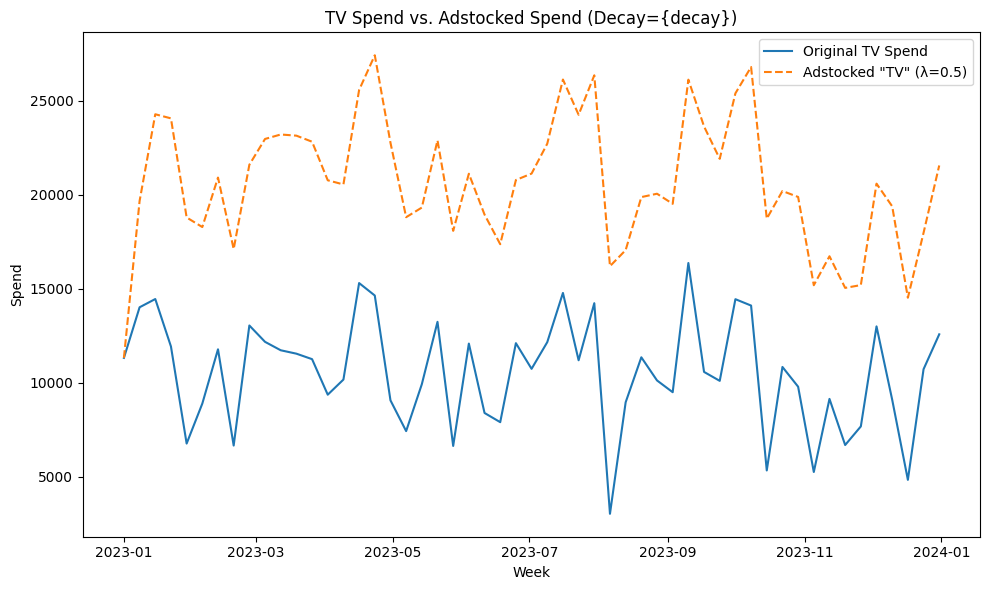

In [24]:
def plot_adstock_corrected(decay=0.5):
    # Filter the media data to get only TV spend
    media_df = offline_marketing[offline_marketing['channel'] == 'TV'][['week', 'spend']].copy()

    # Rename 'spend' column to 'TV' for consistency
    media_df['TV'] = media_df['spend']

    adstock_vals = []
    for i, spend in enumerate(media_df["TV"]):
        if i == 0:
            # initial adstock equals the first spend
            adstock_vals.append(spend)
        else:
            # current adstock = current spend + decay * previous adstock
            adstock_vals.append(spend + decay * adstock_vals[i-1])
    
    media_df['TV_adstock'] = adstock_vals
    
    # 3) Plot
    plt.figure(figsize=(10, 6))
    plt.plot(media_df['week'], media_df["TV"], label=f'Original TV Spend')
    plt.plot(media_df['week'], media_df['TV_adstock'],
             label=f'Adstocked "TV" (λ={decay})', linestyle='--')
    plt.title('TV Spend vs. Adstocked Spend (Decay={decay})')
    plt.xlabel('Week')
    plt.ylabel('Spend')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_adstock_corrected()




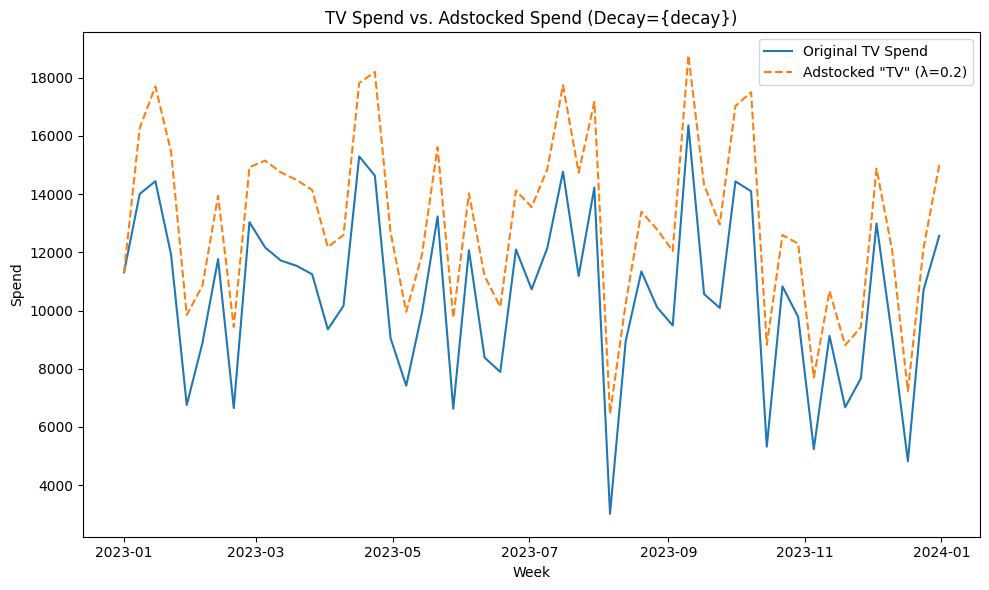

In [25]:
plot_adstock_corrected(decay=0.2)

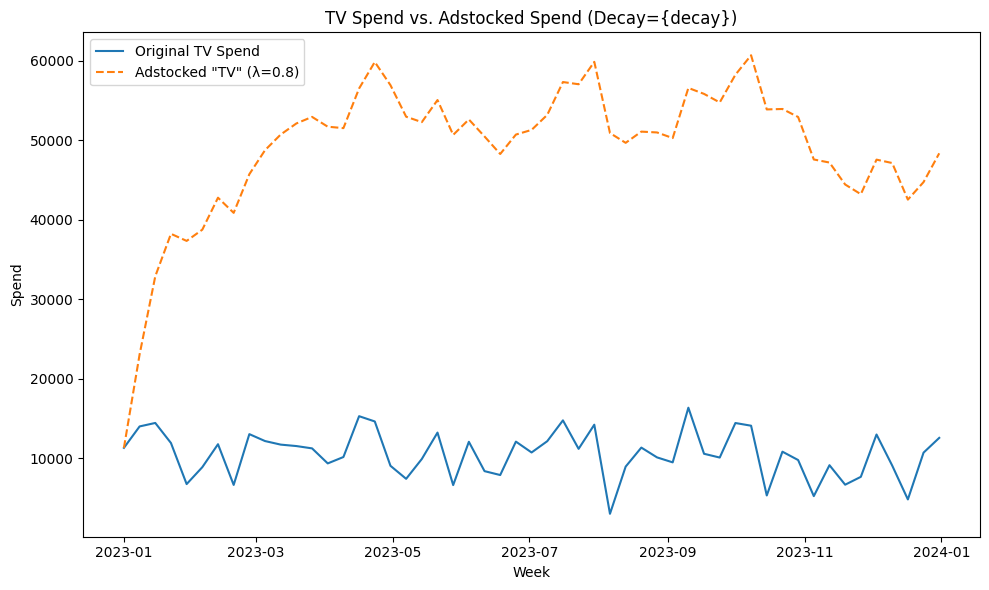

In [26]:
plot_adstock_corrected(decay=0.8)

## Task 2: Misleading Diminishing Returns Visualization (No Saturation Effect)

In [31]:
print(offline_marketing.head(25))

         week channel     spend
0  2023-01-01      TV  11311.42
1  2023-01-01   Radio   6723.33
2  2023-01-01   Print   6214.43
3  2023-01-01     OOH  11230.47
4  2023-01-08      TV  14004.01
5  2023-01-08   Radio   9505.50
6  2023-01-08   Print  11069.60
7  2023-01-08     OOH  11380.75
8  2023-01-15      TV  14442.24
9  2023-01-15   Radio   7836.04
10 2023-01-15   Print   8861.17
11 2023-01-15     OOH  10270.30
12 2023-01-22      TV  11917.89
13 2023-01-22   Radio   6663.51
14 2023-01-22   Print  11601.91
15 2023-01-22     OOH   8335.56
16 2023-01-29      TV   6753.84
17 2023-01-29   Radio  12158.00
18 2023-01-29   Print   7488.18
19 2023-01-29     OOH   9575.21
20 2023-02-05      TV   8881.09
21 2023-02-05   Radio   8960.04
22 2023-02-05   Print   4697.08
23 2023-02-05     OOH  12255.92
24 2023-02-12      TV  11767.96


In [32]:
weekly_sales

,week,total_sales
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040
5,2023-02-05,1007593
6,2023-02-12,1002880
7,2023-02-19,1003058
8,2023-02-26,1003502
9,2023-03-05,1004209


C:\Users\Omkar\AppData\Local\Temp\ipykernel_16680\4204686667.py:5: RuntimeWarning: invalid value encountered in scalar power
  return Vmax * (x ** alpha) / (x ** alpha + K ** alpha)


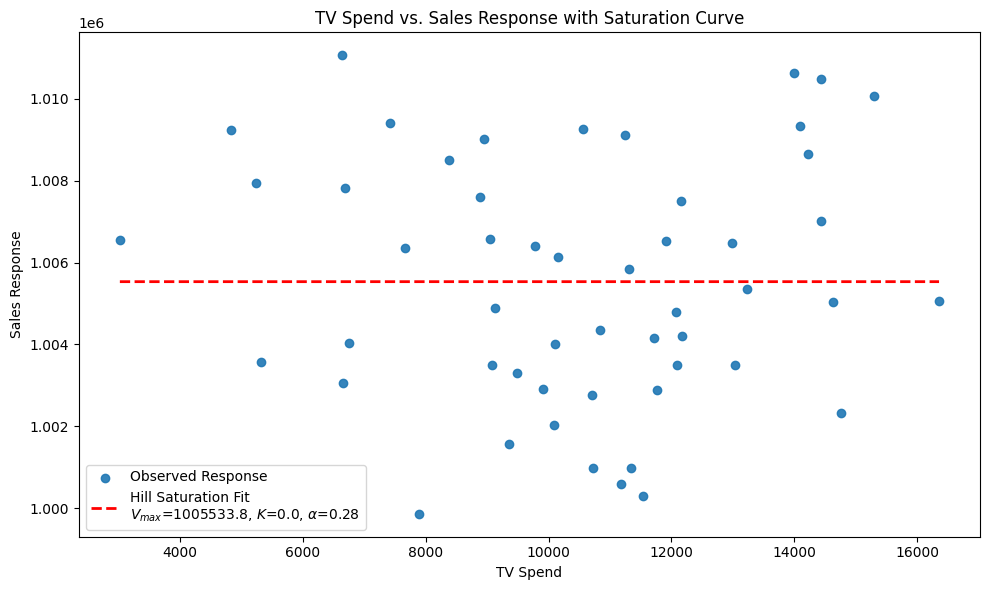

In [59]:

from scipy.optimize import curve_fit

# Define the Hill saturation function
def hill_response(x, Vmax, K, alpha):
    return Vmax * (x ** alpha) / (x ** alpha + K ** alpha)

def plot_diminishing_returns_corrected(offline_marketing, actual_sales):
    x_data = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values
    y_data = actual_sales['total_sales'].values
    
    # Fit the Hill model
    p0 = [max(y_data), np.median(x_data), 1.0]
    params, cov = curve_fit(hill_response, x_data, y_data, p0=p0, maxfev=10_0000)

    Vmax_fit, K_fit, alpha_fit = params
    
    x_range = np.linspace(x_data.min(), x_data.max(), 50)
    y_hat = hill_response(x_range, Vmax_fit, K_fit, alpha_fit)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, label='Observed Response', alpha=0.9)
    plt.plot(x_range, y_hat, 'r--', lw=2,
            label=f'Hill Saturation Fit\n$V_{{max}}$={Vmax_fit:.1f}, $K$={K_fit:.1f}, $\\alpha$={alpha_fit:.2f}')
    plt.title('TV Spend vs. Sales Response with Saturation Curve')
    plt.xlabel('TV Spend')
    plt.ylabel('Sales Response')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_diminishing_returns_corrected(
    offline_marketing[offline_marketing['channel'] == 'TV'][:-1],
    weekly_sales[:-1]
)


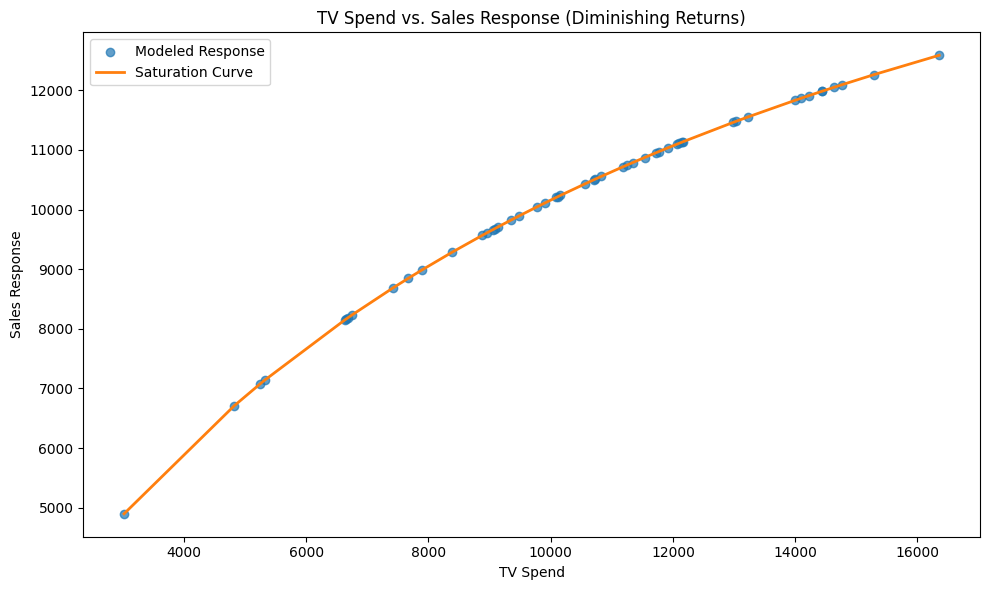

In [ ]:

def plot_adstock_corrected():
  
    tv_spend = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values

    # Parameters for the saturation curve
    # baseline response, maximum lift, and half‐saturation constant
    baseline = 500
    max_lift = 20000
    k = np.median(tv_spend)  # spend at which response is half of max_lift

    # Saturation curve: response = baseline + max_lift * (tv_spend / (tv_spend + k))
    response = baseline + max_lift * (tv_spend / (tv_spend + k))

    # For a smooth trend line, sort by spend
    sort_idx = np.argsort(tv_spend)
    tv_sorted = tv_spend[sort_idx]
    resp_sorted = response[sort_idx]

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(tv_spend, response, color='C0', alpha=0.7, label='Modeled Response')

    # Plot the saturation curve
    plt.plot(tv_sorted, resp_sorted, color='C1', lw=2, label='Saturation Curve')

    # Add titles and labels
    plt.title('TV Spend vs. Sales Response (Diminishing Returns)')
    plt.xlabel('TV Spend')
    plt.ylabel('Sales Response')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_adstock_corrected()


## Task 3: Incorrect Assessment of Interaction Term in Sales Analysis

In [ ]:
offline_channels = ['TV', 'Radio', 'Print', 'OOH']
online_channels = ['Facebook', 'Instagram', 'YouTube', 'Google Ads', 'Influencer Marketing']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def buggy_interaction_analysis():
    """
    Perform Buggy Channel Interaction Analysis by summing all channel spends to create a combined spend term.

    Parameters:
    media_sales (pd.DataFrame): DataFrame containing the merged sales and marketing data.
    offline_channels (list): List of offline marketing channels.
    online_channels (list): List of online marketing channels.
    """
    # Pivot the media_sales data to separate each channel into its own column
    media_sales_pivoted = media_sales.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')

    # Ensure that all offline and online channels are present in the DataFrame, fill missing ones with zeros
    for channel in offline_channels + online_channels:
        if channel not in media_sales_pivoted.columns:
            media_sales_pivoted[channel] = 0  # Fill missing channels with zero spend

    # **Buggy**: Summing all channel spends to create a combined spend (incorrect approach)
    media_sales_pivoted['combined_spend'] = media_sales_pivoted[offline_channels + online_channels].sum(axis=1)

    # **Buggy**: Interaction sales based on the combined spend (incorrect approach)
    media_sales_pivoted['interaction_sales'] = media_sales_pivoted['combined_spend'] * 0.1  # Arbitrary multiplication without proper logic

    # Merge total sales into the pivoted data
    media_sales_pivoted = pd.merge(media_sales_pivoted, media_sales[['week', 'total_sales']], on='week', how='left')

    # Plotting the actual vs misleading interaction sales (incorrect approach)
    plt.figure(figsize=(12, 6))
    plt.plot(media_sales_pivoted['week'], media_sales_pivoted['total_sales'], label='Actual Sales', color='b')
    plt.plot(media_sales_pivoted['week'], media_sales_pivoted['interaction_sales'], label='Misleading Interaction Sales', color='r', linestyle='--')

    plt.title('Buggy Channel Interaction Analysis')
    plt.xlabel('Week')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

buggy_interaction_analysis()


## Task 4: Modeling and Visualizing the Adstock Effect

In [ ]:
# ----------------------------
# BUGGY PLOT 4: Misleading adstock effect wih wrong decay rate
# ----------------------------

def plot_adstock_effect():
    """
    Function to calculate and plot the adstock effect on media spend.

    Parameters:
    - sales_data: DataFrame containing the sales data with 'date' and 'sales_quantity' columns.
    - media_data: DataFrame containing the media spend data with 'week' and 'spend' columns.
    - decay_rate: The decay rate to apply to the lagged spend (default is 0.5).

    Returns:
    - A plot showing the original and adstocked media spend over time.
    """

    decay_rate=0.5

    # Calculate total daily sales to match with marketing data
    daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()
    daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

    # Aggregate weekly sales for comparison with weekly media spend
    weekly_sales = daily_sales.copy()
    weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W').dt.start_time
    weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

    # Merge media spend with weekly sales
    media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')

    # Apply decay rate to model adstock (using the specified decay rate)
    media_sales['TV'] = media_sales['spend']  # Original spend

    # Lag the data by 1 and 2 weeks to represent delayed effects
    media_sales['TV_lag1'] = media_sales['spend'].shift(1) * decay_rate  # Applying decay to lag 1
    media_sales['TV_lag2'] = media_sales['spend'].shift(2) * (decay_rate ** 2)  # Applying decay to lag 2

    # Calculate the adstock effect by summing the original spend with the decayed lags
    media_sales['TV_adstock'] = media_sales['TV'] + media_sales['TV_lag1'] + media_sales['TV_lag2']

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(media_sales['week'], media_sales['TV'], label='Original TV Spend', marker='o')
    plt.plot(media_sales['week'], media_sales['TV_adstock'], label='Adstock with Decay', marker='x', linestyle='--')

    plt.title(f'Adstock Effect with Decay Rate ({decay_rate})')
    plt.xlabel('Week')
    plt.ylabel('Spend')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_adstock_effect()
